# Notebook 1: Sequence Analysis Fundamentals

**Prerequisites for genomic analysis, transcriptomics, and structural biology work**

This notebook builds hands-on fluency with:

- DNA/RNA/protein sequence objects and the [[Hierarchical Composition]] of biological information
- Complement, reverse complement, transcription, translation -- the [[Central Dogma]]
- Pairwise sequence alignment (local and global)
- BLAST searches against NCBI databases
- GenBank/FASTA file parsing
- GC content, codon usage, and sequence statistics
- Restriction enzyme analysis and ORF finding

**Estimated runtime**: ~5 minutes on a laptop (all local, no internet needed for core examples)

---

**Key learning outcomes:**

1. Understand DNA as an information storage molecule, not mysticism
2. Create and manipulate biological sequences programmatically
3. Align sequences and understand scoring matrices (BLOSUM62)
4. Parse real biological data formats (FASTA, GenBank)
5. Compute meaningful biological statistics (GC content, codon usage)

---

## Section 0: Environment Setup

We use **Biopython** (the foundational bioinformatics library in Python). Like Qiskit for quantum computing, Biopython provides the core abstractions for working with biological sequence data.

Biopython gives us `Seq` (the sequence object), `SeqRecord` (annotated sequence), `SeqIO` (file I/O), alignment tools, and access to NCBI databases -- everything needed to go from raw nucleotides to biological insight.

In [1]:
from Bio import SeqIO, Seq, SeqRecord
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import Bio
print(f"Biopython {Bio.__version__} -- ready")

Biopython 1.86 -- ready


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import gc_fraction
from Bio.Data import CodonTable
from Bio import Align
from Bio.Align import substitution_matrices
print("All imports loaded.")

All imports loaded.


---

## Section 1: The DNA Sequence Object

DNA stores information as a sequence of nucleotides:

$$\text{DNA} = (A, T, G, C)^n, \quad \text{where } A \leftrightarrow T, \; G \leftrightarrow C$$

**Key insight**: DNA is NOT just a string. It has directionality (5'->3'), complementarity, and encodes multiple reading frames. A single stretch of DNA can encode different proteins depending on where you start reading -- this is the biological equivalent of a hologram, where the same substrate encodes multiple signals.

The `Seq` object in Biopython captures these biological semantics. It knows about complement base pairing, transcription (DNA->RNA), and translation (RNA->Protein) -- the entire [[Central Dogma]] in a single object.

In [3]:
# Create a DNA sequence (human BRCA1 exon fragment)
dna = Seq("ATGGATTTATCTGCTCTTCGCGTTGAAGAAGTACAAAATGTCATTAATGCTATGCAGAAAATCTTAGAGTGTCCCATCTG")

print(f"Sequence: {dna}")
print(f"Length:   {len(dna)} bp")
print(f"GC content: {gc_fraction(dna):.1%}")
print(f"Complement:         {dna.complement()}")
print(f"Reverse complement: {dna.reverse_complement()}")

Sequence: ATGGATTTATCTGCTCTTCGCGTTGAAGAAGTACAAAATGTCATTAATGCTATGCAGAAAATCTTAGAGTGTCCCATCTG
Length:   80 bp
GC content: 37.5%
Complement:         TACCTAAATAGACGAGAAGCGCAACTTCTTCATGTTTTACAGTAATTACGATACGTCTTTTAGAATCTCACAGGGTAGAC
Reverse complement: CAGATGGGACACTCTAAGATTTTCTGCATAGCATTAATGACATTTTGTACTTCTTCAACGCGAAGAGCAGATAAATCCAT


In [4]:
# The Central Dogma: DNA -> RNA -> Protein
mrna = dna.transcribe()
print(f"mRNA:    {mrna}")

protein = dna.translate()
print(f"Protein: {protein}")
print(f"Protein length: {len(protein)} amino acids")

# Stop codon appears as '*'
print(f"Contains stop codon: {'*' in str(protein)}")

mRNA:    AUGGAUUUAUCUGCUCUUCGCGUUGAAGAAGUACAAAAUGUCAUUAAUGCUAUGCAGAAAAUCUUAGAGUGUCCCAUCUG
Protein: MDLSALRVEEVQNVINAMQKILECPI
Protein length: 26 amino acids
Contains stop codon: False


/Users/caseyfrankenberger/Documents/Obsidian Vault/Bioinformatics/Compute/.venv/lib/python3.14/site-packages/Bio/Seq.py:2877: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [5]:
# DNA has 6 reading frames (3 forward, 3 reverse)
print("Forward reading frames:")
for i in range(3):
    prot = dna[i:].translate()
    print(f"  Frame +{i+1}: {prot[:20]}...")

print("\nReverse reading frames:")
rc = dna.reverse_complement()
for i in range(3):
    prot = rc[i:].translate()
    print(f"  Frame -{i+1}: {prot[:20]}...")

Forward reading frames:
  Frame +1: MDLSALRVEEVQNVINAMQK...
  Frame +2: WIYLLFALKKYKMSLMLCRK...
  Frame +3: GFICSSR*RSTKCH*CYAEN...

Reverse reading frames:
  Frame -1: QMGHSKIFCIALMTFCTSST...
  Frame -2: RWDTLRFSA*H**HFVLLQR...
  Frame -3: DGTL*DFLHSINDILYFFNA...


---

## Section 2: Sequence Statistics and Visualization

Sequence composition reveals biological function. GC content varies across genomes (25-75%), affects melting temperature, and distinguishes coding from non-coding regions.

- **High GC** (~60-70%): thermophilic bacteria, gene-rich regions in vertebrates
- **Low GC** (~30-40%): AT-rich organisms (Plasmodium), intergenic regions
- **Sliding windows**: reveal local composition variation along a chromosome

These statistics connect to [[Information Compression in Biology]] -- the nucleotide alphabet is a 2-bit encoding (4 bases = 2 bits per position), and deviations from uniform composition signal functional constraint.

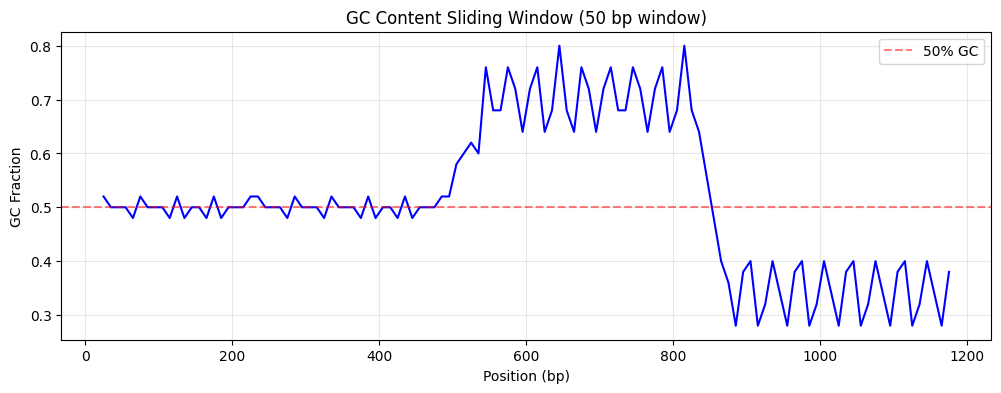

In [6]:
# GC content sliding window (common in genome analysis)
# Using a synthetic bacterial genome fragment
genome_fragment = Seq(
    "ATGGCGCTAGCATCGATCGTAGCTAGCATCGATCGCGCGCGCATATATATAT" * 10 +
    "GCGCGCGCGCGCGCTAGCTAGCTAGCATCGATCG" * 10 +
    "ATATATATATATGCATGCATGCATCGATCGATCGA" * 10
)

window_size = 50
step = 10
gc_values = []
positions = []

for i in range(0, len(genome_fragment) - window_size, step):
    window = genome_fragment[i:i + window_size]
    gc_values.append(gc_fraction(window))
    positions.append(i + window_size // 2)

plt.figure(figsize=(12, 4))
plt.plot(positions, gc_values, 'b-', linewidth=1.5)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% GC')
plt.xlabel('Position (bp)')
plt.ylabel('GC Fraction')
plt.title('GC Content Sliding Window (50 bp window)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

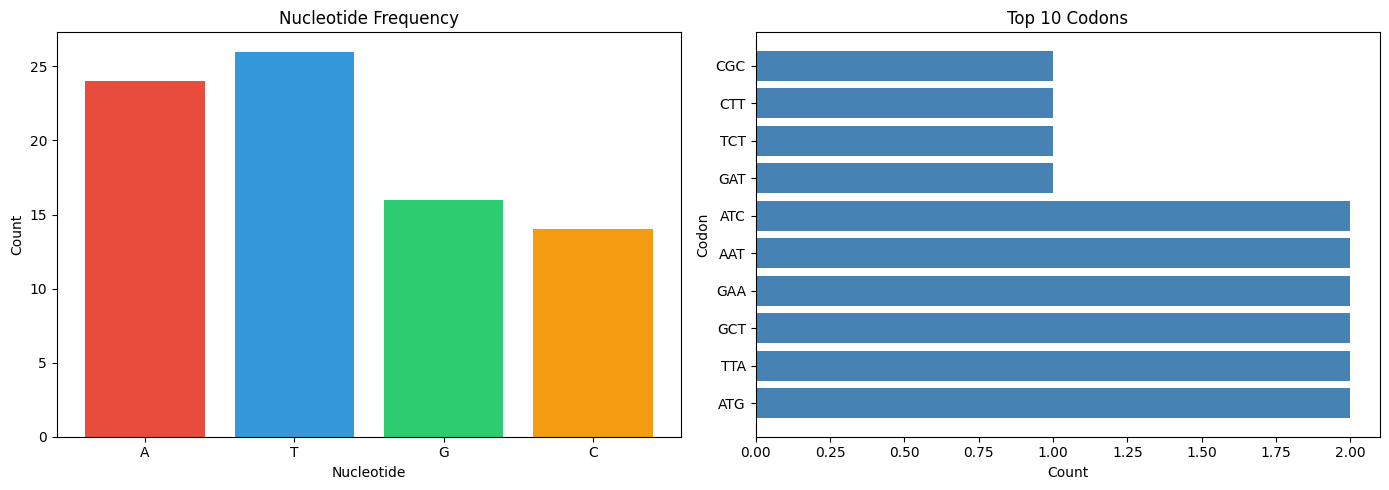

In [7]:
# Nucleotide frequency
nt_counts = Counter(str(dna))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = {'A': '#e74c3c', 'T': '#3498db', 'G': '#2ecc71', 'C': '#f39c12'}
ax1.bar(nt_counts.keys(), nt_counts.values(),
        color=[colors[nt] for nt in nt_counts.keys()])
ax1.set_xlabel('Nucleotide')
ax1.set_ylabel('Count')
ax1.set_title('Nucleotide Frequency')

# Codon usage
codons = [str(dna[i:i+3]) for i in range(0, len(dna) - 2, 3)]
codon_counts = Counter(codons)
top_codons = codon_counts.most_common(10)
ax2.barh([c[0] for c in top_codons], [c[1] for c in top_codons], color='steelblue')
ax2.set_xlabel('Count')
ax2.set_ylabel('Codon')
ax2.set_title('Top 10 Codons')

plt.tight_layout()
plt.show()

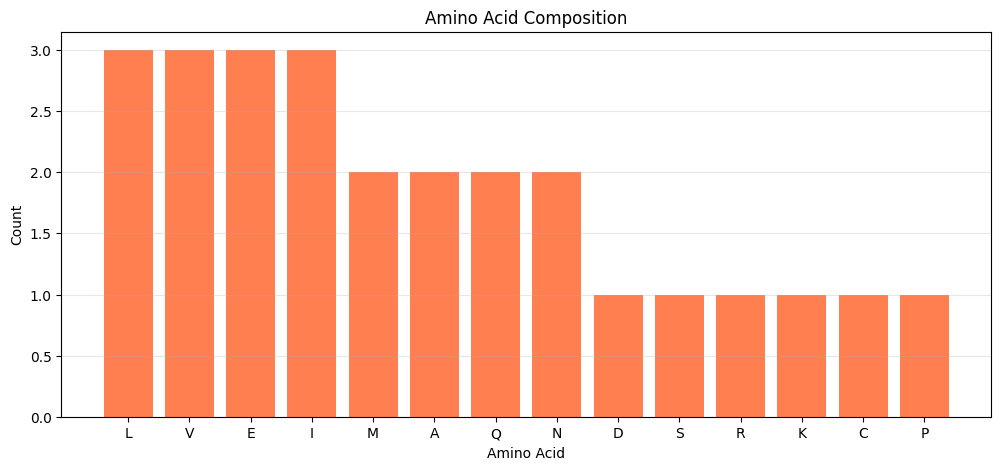

Most common:  L (3x)
Least common: P (1x)


In [8]:
# Amino acid composition of the translated protein
protein_str = str(dna.translate()).replace('*', '')
aa_counts = Counter(protein_str)
aa_sorted = sorted(aa_counts.items(), key=lambda x: -x[1])

plt.figure(figsize=(12, 5))
plt.bar([aa[0] for aa in aa_sorted], [aa[1] for aa in aa_sorted], color='coral')
plt.xlabel('Amino Acid')
plt.ylabel('Count')
plt.title('Amino Acid Composition')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

print(f"Most common:  {aa_sorted[0][0]} ({aa_sorted[0][1]}x)")
print(f"Least common: {aa_sorted[-1][0]} ({aa_sorted[-1][1]}x)")

---

## Section 3: Pairwise Sequence Alignment

Sequence alignment is the fundamental operation of bioinformatics. It reveals evolutionary relationships, functional conservation, and structural similarity. Reference [[Fitness Landscapes]] -- alignment scores measure distance in sequence space.

Two types:

- **Global alignment** (Needleman-Wunsch): align entire sequences end-to-end. Use when sequences are similar length and expected to be homologous over their full extent.
- **Local alignment** (Smith-Waterman): find the best matching subsequence. Use when looking for conserved domains within larger, dissimilar sequences.

**Scoring**: match reward, mismatch penalty, gap penalty. For proteins, use substitution matrices (BLOSUM62) that encode evolutionary substitution rates -- amino acids with similar chemical properties substitute more frequently and receive higher scores.

In [9]:
# Create a PairwiseAligner (modern Biopython API)
aligner = Align.PairwiseAligner()

# Global alignment of two similar DNA sequences
seq1 = Seq("ATCGATCGATCG")
seq2 = Seq("ATCAATCGATCG")  # One substitution

aligner.mode = 'global'
aligner.match_score = 2
aligner.mismatch_score = -1
aligner.open_gap_score = -2
aligner.extend_gap_score = -0.5

alignments = aligner.align(seq1, seq2)
best = alignments[0]
print("Global DNA Alignment:")
print(best)
print(f"Score: {best.score}")

Global DNA Alignment:
target            0 ATCGATCGATCG 12
                  0 |||.|||||||| 12
query             0 ATCAATCGATCG 12

Score: 21.0


In [10]:
# Protein alignment using BLOSUM62 substitution matrix
aligner_prot = Align.PairwiseAligner()
aligner_prot.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner_prot.open_gap_score = -10
aligner_prot.extend_gap_score = -0.5

# Two related protein fragments (hemoglobin alpha vs beta)
prot1 = Seq("VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSH")
prot2 = Seq("VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLST")

alignments_prot = aligner_prot.align(prot1, prot2)
best_prot = alignments_prot[0]
print("Protein Alignment (BLOSUM62):")
print(best_prot)
print(f"Score: {best_prot.score}")

Protein Alignment (BLOSUM62):
target            0 V-LSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHF-DLSH 50
                  0 |-|.|..|..|.|.||||--...|.|.|||.|.....|.|...|..|-|||. 52
query             0 VHLTPEEKSAVTALWGKV--NVDEVGGEALGRLLVVYPWTQRFFESFGDLST 50

Score: 87.5


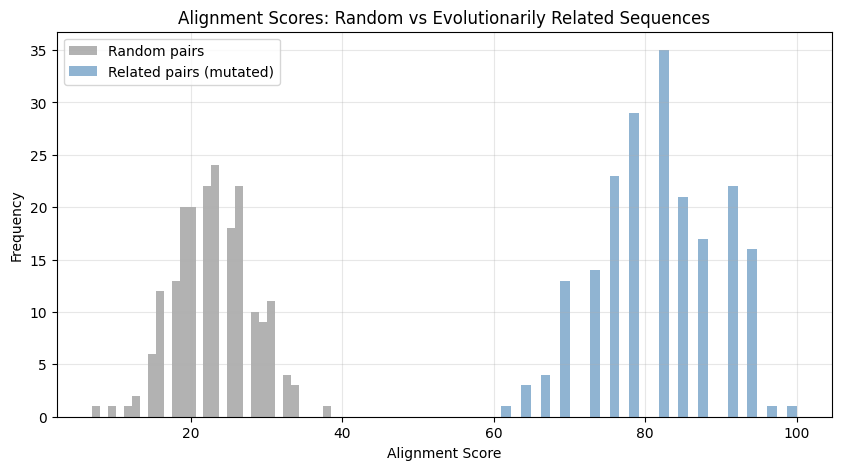

Random mean:  22.9 +/- 5.1
Related mean: 81.7 +/- 7.7


In [11]:
# Compare alignment scores: related vs random sequences
import random

def random_dna(length):
    return Seq(''.join(random.choices('ATGC', k=length)))

# Generate scores for random pairs
random_scores = []
for _ in range(200):
    s1 = random_dna(50)
    s2 = random_dna(50)
    aln = aligner.align(s1, s2)
    random_scores.append(aln[0].score)

# Generate scores for related pairs (mutate original)
related_scores = []
original = random_dna(50)
for _ in range(200):
    mutated = list(str(original))
    n_mutations = random.randint(3, 15)
    for _ in range(n_mutations):
        pos = random.randint(0, 49)
        mutated[pos] = random.choice('ATGC')
    s2 = Seq(''.join(mutated))
    aln = aligner.align(original, s2)
    related_scores.append(aln[0].score)

plt.figure(figsize=(10, 5))
plt.hist(random_scores, bins=30, alpha=0.6, label='Random pairs', color='gray')
plt.hist(related_scores, bins=30, alpha=0.6, label='Related pairs (mutated)', color='steelblue')
plt.xlabel('Alignment Score')
plt.ylabel('Frequency')
plt.title('Alignment Scores: Random vs Evolutionarily Related Sequences')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Random mean:  {np.mean(random_scores):.1f} +/- {np.std(random_scores):.1f}")
print(f"Related mean: {np.mean(related_scores):.1f} +/- {np.std(related_scores):.1f}")

---

## Section 4: Parsing Biological Data Files

Real bioinformatics starts with parsing files. The two most common formats:

- **FASTA**: Simple sequence + header. Used everywhere. One line starting with `>` for the header, followed by the sequence on subsequent lines.
- **GenBank**: Rich annotation (genes, features, references). NCBI standard. Contains metadata, feature tables with coordinates, and the raw sequence.

Biopython's `SeqIO` module provides a unified interface for reading and writing dozens of biological file formats -- the same `SeqIO.parse()` call works for FASTA, GenBank, EMBL, SwissProt, and more.

In [12]:
# Create SeqRecord objects (the core Biopython data structure)
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
import io

records = [
    SeqRecord(Seq("ATGGCGCTAGCATCGATCG"), id="gene_001", description="hypothetical protein"),
    SeqRecord(Seq("ATGAAACCCGGGTTTTAA"), id="gene_002", description="ribosomal protein S1"),
    SeqRecord(Seq("ATGCATCATCATCATCAT"), id="gene_003", description="histidine-rich protein"),
]

# Write to FASTA string
fasta_output = io.StringIO()
SeqIO.write(records, fasta_output, "fasta")
fasta_text = fasta_output.getvalue()
print("FASTA output:")
print(fasta_text)

# Parse it back
fasta_input = io.StringIO(fasta_text)
for record in SeqIO.parse(fasta_input, "fasta"):
    print(f"ID: {record.id}, Length: {len(record.seq)} bp, GC: {gc_fraction(record.seq):.1%}")

FASTA output:
>gene_001 hypothetical protein
ATGGCGCTAGCATCGATCG
>gene_002 ribosomal protein S1
ATGAAACCCGGGTTTTAA
>gene_003 histidine-rich protein
ATGCATCATCATCATCAT

ID: gene_001, Length: 19 bp, GC: 57.9%
ID: gene_002, Length: 18 bp, GC: 38.9%
ID: gene_003, Length: 18 bp, GC: 33.3%


In [13]:
# Create a richly annotated record
from Bio.SeqFeature import SeqFeature, SimpleLocation

genome = SeqRecord(
    Seq("ATGGCGCTAGCATCGATCGTAGCTAGCATCGATCGCGCGCGCATATATATAT"),
    id="NC_000001",
    name="example_genome",
    description="Example bacterial genome fragment"
)

# Add gene features
genome.features.append(
    SeqFeature(SimpleLocation(0, 30), type="gene", qualifiers={"gene": ["geneA"]})
)
genome.features.append(
    SeqFeature(SimpleLocation(30, 51), type="gene", qualifiers={"gene": ["geneB"]})
)

print(f"Genome: {genome.id}, {len(genome.seq)} bp")
for feat in genome.features:
    gene_name = feat.qualifiers.get('gene', ['unknown'])[0]
    print(f"  Feature: {feat.type} '{gene_name}' at {feat.location}")
    print(f"    Sequence: {feat.extract(genome.seq)}")

Genome: NC_000001, 52 bp
  Feature: gene 'geneA' at [0:30]
    Sequence: ATGGCGCTAGCATCGATCGTAGCTAGCATC
  Feature: gene 'geneB' at [30:51]
    Sequence: GATCGCGCGCGCATATATATA


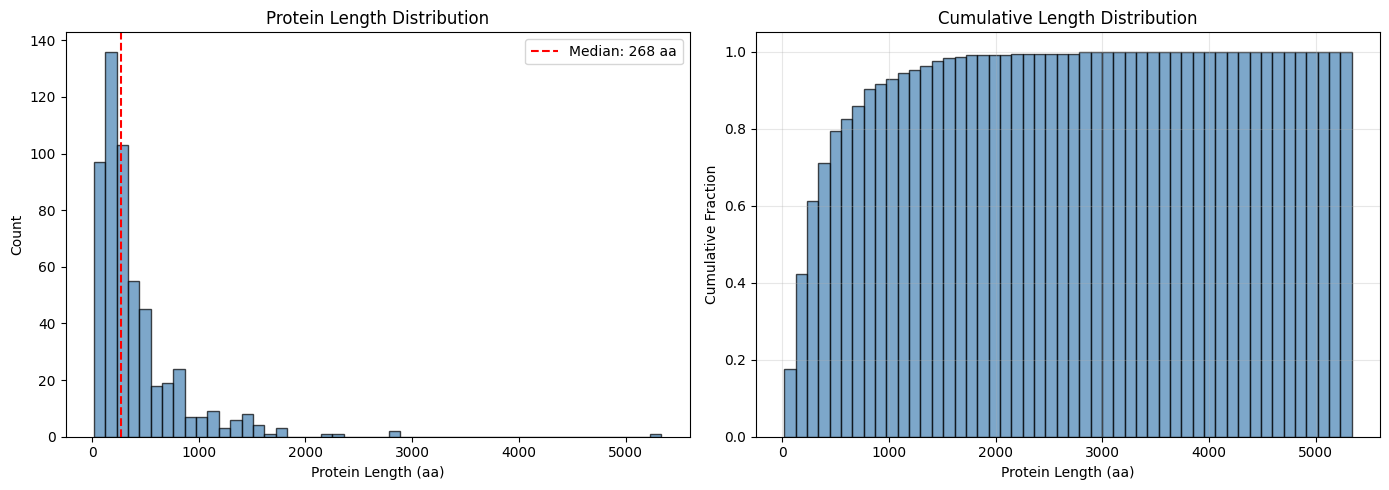

Total proteins: 550
Mean length: 407 aa
Median length: 268 aa
Longest: 5335 aa


In [14]:
# Simulate parsing a multi-FASTA file (e.g., a proteome)
np.random.seed(42)
lengths = np.concatenate([
    np.random.lognormal(5.5, 0.8, 500),  # Main population
    np.random.lognormal(7.0, 0.5, 50),    # Large proteins
])
lengths = lengths.astype(int)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Protein Length (aa)')
ax1.set_ylabel('Count')
ax1.set_title('Protein Length Distribution')
ax1.axvline(np.median(lengths), color='red', linestyle='--',
            label=f'Median: {np.median(lengths):.0f} aa')
ax1.legend()

ax2.hist(lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7,
         cumulative=True, density=True)
ax2.set_xlabel('Protein Length (aa)')
ax2.set_ylabel('Cumulative Fraction')
ax2.set_title('Cumulative Length Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total proteins: {len(lengths)}")
print(f"Mean length: {np.mean(lengths):.0f} aa")
print(f"Median length: {np.median(lengths):.0f} aa")
print(f"Longest: {max(lengths)} aa")

---

## Section 5: Restriction Enzyme Analysis

Restriction enzymes are molecular scissors that cut DNA at specific recognition sites. They are foundational tools in molecular cloning -- the original "copy-paste" of genetic engineering, predating CRISPR by decades.

Each enzyme recognizes a specific palindromic sequence (reads the same on both strands). For example, EcoRI recognizes `GAATTC` and cuts between the G and A on both strands, leaving "sticky ends" that can be ligated to other fragments.

Reference [[Domain as Modular Unit]] -- restriction enzymes enable modular DNA construction, treating genes as interchangeable parts.

In [15]:
from Bio.Restriction import EcoRI, BamHI, HindIII, RestrictionBatch

# A DNA sequence with known restriction sites
dna_construct = Seq(
    "AATTCGAATTCGATCGATCGATGGATCCATCGATCGAAGCTTAATCGATCGGAATTCAA"
)

# Search for common enzymes
rb = RestrictionBatch([EcoRI, BamHI, HindIII])
results = rb.search(dna_construct)

print(f"Sequence ({len(dna_construct)} bp): {dna_construct}")
print("\nRestriction sites found:")
for enzyme, positions in results.items():
    if positions:
        print(f"  {enzyme}: cuts at positions {positions}")
    else:
        print(f"  {enzyme}: no sites")

Sequence (59 bp): AATTCGAATTCGATCGATCGATGGATCCATCGATCGAAGCTTAATCGATCGGAATTCAA

Restriction sites found:
  EcoRI: cuts at positions [7, 53]
  BamHI: cuts at positions [24]
  HindIII: cuts at positions [38]


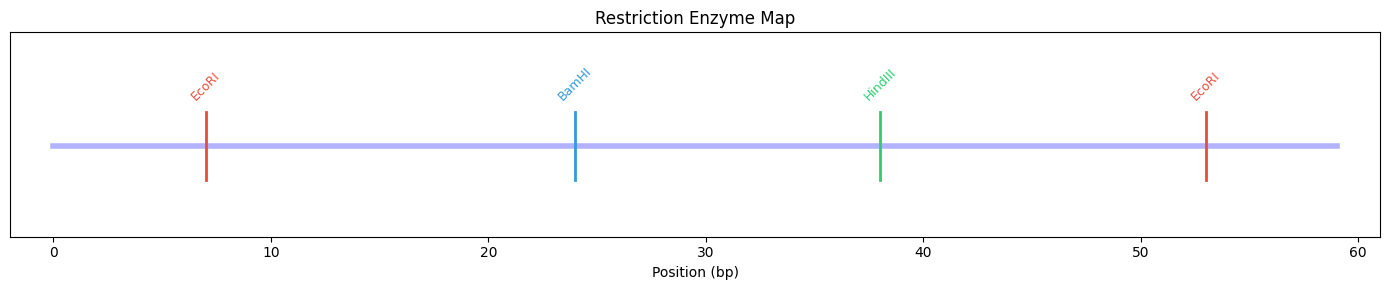

In [16]:
# Visualize restriction map
fig, ax = plt.subplots(figsize=(14, 3))

# Draw the DNA as a line
ax.plot([0, len(dna_construct)], [0, 0], 'b-', linewidth=4, alpha=0.3)

colors_map = {'EcoRI': '#e74c3c', 'BamHI': '#3498db', 'HindIII': '#2ecc71'}
for enzyme, positions in results.items():
    for pos in positions:
        color = colors_map.get(str(enzyme), 'gray')
        ax.plot([pos, pos], [-0.3, 0.3], color=color, linewidth=2)
        ax.text(pos, 0.4, str(enzyme), ha='center', fontsize=9,
                color=color, rotation=45)

ax.set_xlim(-2, len(dna_construct) + 2)
ax.set_ylim(-0.8, 1.0)
ax.set_xlabel('Position (bp)')
ax.set_title('Restriction Enzyme Map')
ax.set_yticks([])
plt.tight_layout()
plt.show()

---

## Section 6: The Codon Table and Genetic Code

The genetic code maps 64 codons to 20 amino acids + stop signals. This redundancy (degeneracy) is NOT random -- it minimizes the impact of point mutations. Most single-nucleotide changes in the third codon position ("wobble position") produce either the same amino acid or one with similar chemical properties.

This is a deep example of [[Degeneracy in Biological Systems]] and [[Functional Equivalence Classes]] -- multiple genotypes mapping to the same phenotype. The code is structured so that the most common types of mutations (transitions at the wobble position) are the least likely to change protein function.

The genetic code also connects to [[Evolutionary Tinkering]] -- it is nearly universal across all life, suggesting it was optimized early and then frozen by the "frozen accident" of translational machinery co-evolution.

In [17]:
# Display the standard genetic code
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]

print("Standard Genetic Code:")
print(f"  Start codons: {standard_table.start_codons}")
print(f"  Stop codons:  {standard_table.stop_codons}")
print(f"\n  Codon -> Amino Acid mapping:")

# Build codon table matrix
bases = ['T', 'C', 'A', 'G']
print(f"\n{'':>8}", end='')
for b2 in bases:
    print(f"{'--- ' + b2 + ' ---':>12}", end='')
print()

for b1 in bases:
    for b3 in bases:
        print(f"  {b1}..{b3}  ", end='')
        for b2 in bases:
            codon = b1 + b2 + b3
            if codon in standard_table.stop_codons:
                aa = 'STOP'
            else:
                aa = standard_table.forward_table[codon]
            print(f"{codon}={aa:<4}", end='  ')
        print()
    print()

Standard Genetic Code:
  Start codons: ['TTG', 'CTG', 'ATG']
  Stop codons:  ['TAA', 'TAG', 'TGA']

  Codon -> Amino Acid mapping:

           --- T ---   --- C ---   --- A ---   --- G ---
  T..T  TTT=F     TCT=S     TAT=Y     TGT=C     
  T..C  TTC=F     TCC=S     TAC=Y     TGC=C     
  T..A  TTA=L     TCA=S     TAA=STOP  TGA=STOP  
  T..G  TTG=L     TCG=S     TAG=STOP  TGG=W     

  C..T  CTT=L     CCT=P     CAT=H     CGT=R     
  C..C  CTC=L     CCC=P     CAC=H     CGC=R     
  C..A  CTA=L     CCA=P     CAA=Q     CGA=R     
  C..G  CTG=L     CCG=P     CAG=Q     CGG=R     

  A..T  ATT=I     ACT=T     AAT=N     AGT=S     
  A..C  ATC=I     ACC=T     AAC=N     AGC=S     
  A..A  ATA=I     ACA=T     AAA=K     AGA=R     
  A..G  ATG=M     ACG=T     AAG=K     AGG=R     

  G..T  GTT=V     GCT=A     GAT=D     GGT=G     
  G..C  GTC=V     GCC=A     GAC=D     GGC=G     
  G..A  GTA=V     GCA=A     GAA=E     GGA=G     
  G..G  GTG=V     GCG=A     GAG=E     GGG=G     



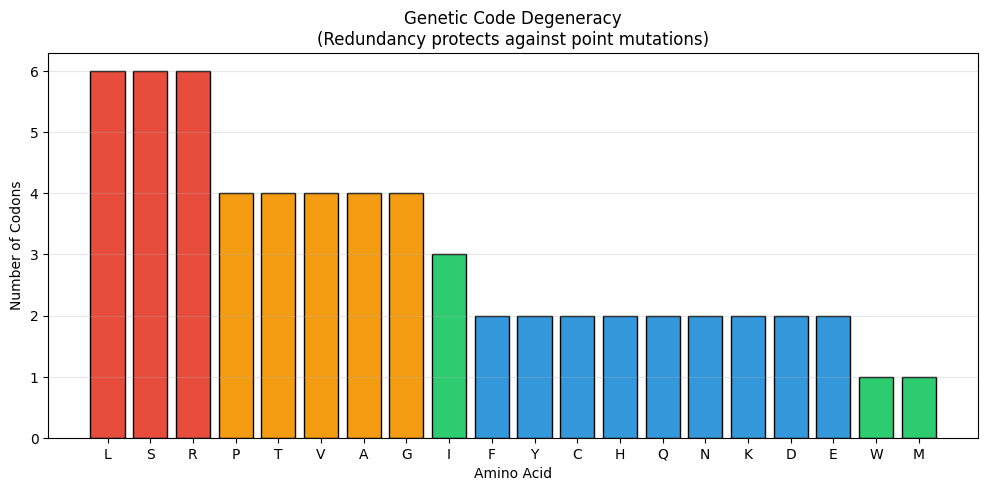

6-fold degenerate (Leu, Ser, Arg): most protected
1-fold degenerate (Met, Trp): most vulnerable to mutation


In [18]:
# How many codons encode each amino acid?
from collections import defaultdict

aa_to_codons = defaultdict(list)
for codon, aa in standard_table.forward_table.items():
    aa_to_codons[aa].append(codon)

degeneracy = {aa: len(codons) for aa, codons in aa_to_codons.items()}
deg_sorted = sorted(degeneracy.items(), key=lambda x: -x[1])

plt.figure(figsize=(12, 5))
colors_deg = [
    '#e74c3c' if d[1] == 6 else
    '#f39c12' if d[1] == 4 else
    '#3498db' if d[1] == 2 else
    '#2ecc71'
    for d in deg_sorted
]
plt.bar([d[0] for d in deg_sorted], [d[1] for d in deg_sorted],
        color=colors_deg, edgecolor='black')
plt.xlabel('Amino Acid')
plt.ylabel('Number of Codons')
plt.title('Genetic Code Degeneracy\n(Redundancy protects against point mutations)')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

print(f"6-fold degenerate (Leu, Ser, Arg): most protected")
print(f"1-fold degenerate (Met, Trp): most vulnerable to mutation")

---

## Summary

| Concept | What you built | Why it matters |
|---------|---------------|----------------|
| Seq objects | DNA/RNA/protein manipulation | Foundation for all bioinformatics |
| Central Dogma | Transcription/translation | DNA -> RNA -> Protein pipeline |
| Alignment | Pairwise scoring | Detect evolutionary relationships |
| File parsing | FASTA/GenBank | Work with real biological databases |
| GC content | Sliding window analysis | Genome structure and function |
| Restriction map | Enzyme site finding | Molecular cloning and engineering |
| Codon degeneracy | Genetic code analysis | Understanding [[Degeneracy in Biological Systems]] |

**Next**: [[02_Genomic_Variant_Analysis]] -- population genetics, variants, and GWAS